In [ ]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [ ]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [ ]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

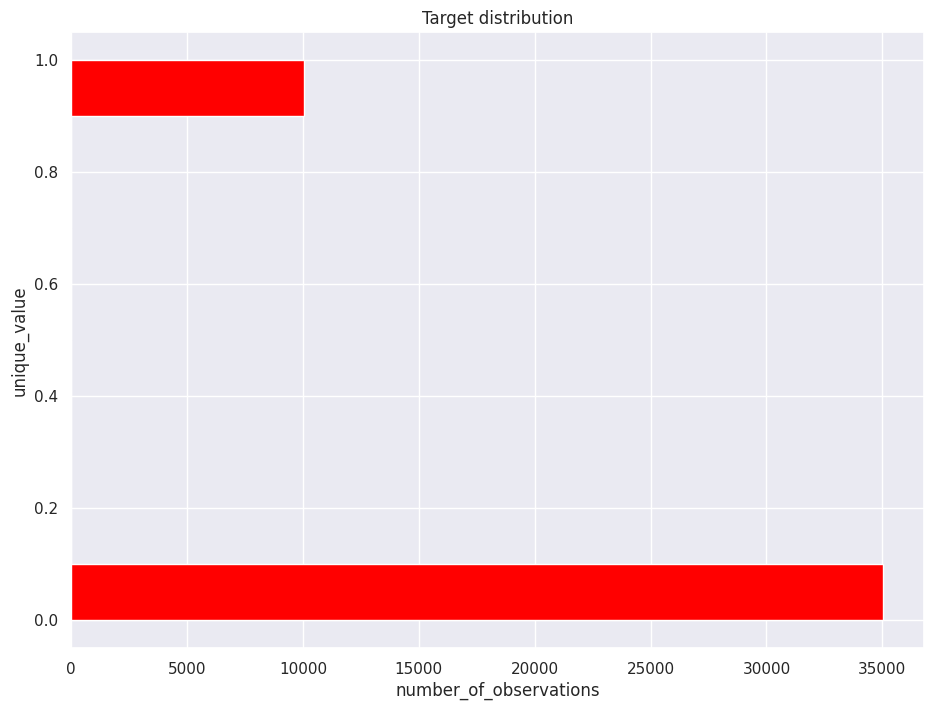

In [ ]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [ ]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [ ]:
table = data.fillna(data.mean())

In [ ]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

#BOOTSTRAPPING

In [ ]:
np.random.seed(0)

In [ ]:
churn = data[data["SeriousDlqin2yrs"] == 1]["age"].values

In [ ]:
def get_bootstrap_samples(data, n):
  indices = np.random.randint(0, len(data), (n, len(data)))
  samples = data[indices]
  return samples

def stat_intervals(stat, alpha):
  bound = np.percentile(stat, [100*alpha/2, 100*(1-alpha)/2])
  return bound

churn_mean = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]
print("Mean scores: ", stat_intervals(churn_mean, 0.1))

Mean scores:  [45.71379414 45.90784959]


#LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [ ]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [ ]:
grid_search = GridSearchCV(lr, parameters, n_jobs = -1, scoring = "roc_auc", cv = skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', random_state=5)

In [ ]:
grid_search.cv_results_["std_test_score"][1]

0.00447290922444772

In [ ]:
grid_search.best_score_

0.8092635905321993

#Feature Importance

In [ ]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C = 0.1, random_state=5, class_weight='balanced')
sc = StandardScaler()
lr.fit(sc.fit_transform(X), y)

pd.DataFrame({"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,3.112945
3,NumberOfTimes90DaysLate,2.805663
4,NumberOfTime60-89DaysPastDueNotWorse,0.202107
6,NumberOfDependents,0.082248
2,DebtRatio,-0.035338
5,MonthlyIncome,-0.209420
0,age,-0.436760


In [ ]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.022059812761371478


In [ ]:
lr = LogisticRegression(C=0.1, random_state = 5, class_weight = "balanced")
lr.fit(X, y)

pd.DataFrame({"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.501396
3,NumberOfTimes90DaysLate,0.454267
4,NumberOfTime60-89DaysPastDueNotWorse,0.384101
6,NumberOfDependents,0.078646
5,MonthlyIncome,-0.000006
2,DebtRatio,-0.000010
0,age,-0.012182


In [ ]:
np.exp(lr.coef_[0][0] * 20)

0.7837667472099314

#RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=42, class_weight="balanced")

In [ ]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [ ]:
rf_grid_search = GridSearchCV(rf, parameters, n_jobs = -1, scoring = "roc_auc", cv = skf, verbose = True)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.02616812306183447


In [ ]:
independent_columns_names[np.argmin(rf_grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

In [ ]:
pd.DataFrame({
    "feat": independent_columns_names,
    "coef": rf_grid_search.best_estimator_.feature_importances_
}).sort_values(by="coef", ascending=False)

,feat,coef
3,NumberOfTimes90DaysLate,0.315885
1,NumberOfTime30-59DaysPastDueNotWorse,0.297313
4,NumberOfTime60-89DaysPastDueNotWorse,0.127704
0,age,0.100779
2,DebtRatio,0.088006
5,MonthlyIncome,0.058639
6,NumberOfDependents,0.011673


#BAGGING

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [ ]:
bg = BaggingClassifier(
    LogisticRegression(class_weight="balanced"),
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True,
)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
print(r_grid_search.best_score_)

0.808533466356393
